In [1]:
%matplotlib inline
import json
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
fidWhite = os.path.join('sample_data','white_mouse_100_output.manifest')

# first read the json for each mouse:
data_White = []
for line in open(fidWhite,'r'):
    data_White.append(json.loads(line))


In [3]:
nSamp = len(data_White)
nKpts = 7
order = ['nose','right ear','left ear','top of neck','right rear knee','left rear knee','base of tail']

rawPts = np.zeros((nSamp,nKpts,2,6)) # for each image: 7 keypoints, 2 dimensions, 6 workers per keypoint

images = ['']*nSamp        # track paths to labeled images
hits = [False]*nSamp       # track which images have annotations (only needed if a job failed to complete)
workerCount = [0]*nSamp    # track the number of workers who labeled each image (only needed if a job failed to complete)


# optional: replace the path to the image in the s3 bucket with a path to its location on the local machine
DOLOCAL = True
sourceStr = os.path.dirname(data_White[0]['source-ref'])
pth = 'D:\\Dropbox\\research\\SFARI_MARS\\AMT_reannotation\\datasets\\white_100\\'

# name for the dict containing annotation data- this was set in run_labeling_job
keyName = 'annotatedResult'

for f,frame in enumerate(data_White):
    if (keyName in frame.keys()): #check if this frame has at least one set of annotations
        hits[f] = True
        
        images[f] = frame['source-ref']
        if DOLOCAL:
            images[f] = images[f].replace(sourceStr,pth) # load from local path
        
        for w,worker in enumerate(frame[keyName]['annotationsFromAllWorkers']):
            workerCount[f] = workerCount[f] + 1
            
            # the json of annotations from each worker is stored as a string for security reasons.
            # we'll use eval to convert it into a dict:
            annot = eval(worker['annotationData']['content'])

            # now we can unpack this worker's annotations for each keypoint:
            for pt in annot[keyName]['keypoints']:
                idx = order.index(pt['label'])
                rawPts[f,idx,0,w] = pt['x']
                rawPts[f,idx,1,w] = pt['y']


In [4]:
# we're going to set our ground-truth points as the geometric median of all the annotators.
# This algorithm for the geometric median comes from Vardi and Zhang 1999, as implemented by orlp on Stack Overflow
# (https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points)
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [21]:
# now let's get our ground-truth keypoints. first we'll take medians of the raw keypoints:
gtPtsRaw = np.zeros((nSamp,nKpts,2))
for f,frame in enumerate(rawPts):
    for p,pt in enumerate(frame):
        gtPtsRaw[f,p,:] = geometric_median(np.squeeze(pt.T))

# iteratively adjust L/R assignments to try to find better median estimates
for rep in range(5):
    # next, for ears and hips we should check for + correct Left/Right swaps, a common annotator mistake:
    allPts = np.copy(rawPts)
    for fr,(gt,frame) in enumerate(zip(gtPtsRaw,rawPts)):
        for w,worker in enumerate(frame.swapaxes(0,2).swapaxes(1,2)):
            dEar1 = cdist(worker[1:3,:],[gt[1]])
            dEar2 = cdist(worker[1:3,:],[gt[2]])
            if (dEar1[0]>dEar1[1]) and (dEar2[1]>dEar1[0]):
                allPts[fr,1,:,w] = rawPts[fr,2,:,w]
                allPts[fr,2,:,w] = rawPts[fr,1,:,w]
            dHip1 = cdist(worker[4:6,:],[gt[4]])
            dHip2 = cdist(worker[4:6,:],[gt[5]])
            if (dHip1[0]>dHip1[1]) and (dHip2[1]>dHip2[0]):
                allPts[fr,4,:,w] = rawPts[fr,5,:,w]
                allPts[fr,5,:,w] = rawPts[fr,4,:,w]

    # finally, re-compute the medians:
    gtPts = np.zeros((nSamp,nKpts,2))
    for f,frame in enumerate(allPts):
        for p,pt in enumerate(frame):
            gtPts[f,p,:] = geometric_median(np.squeeze(pt.T))

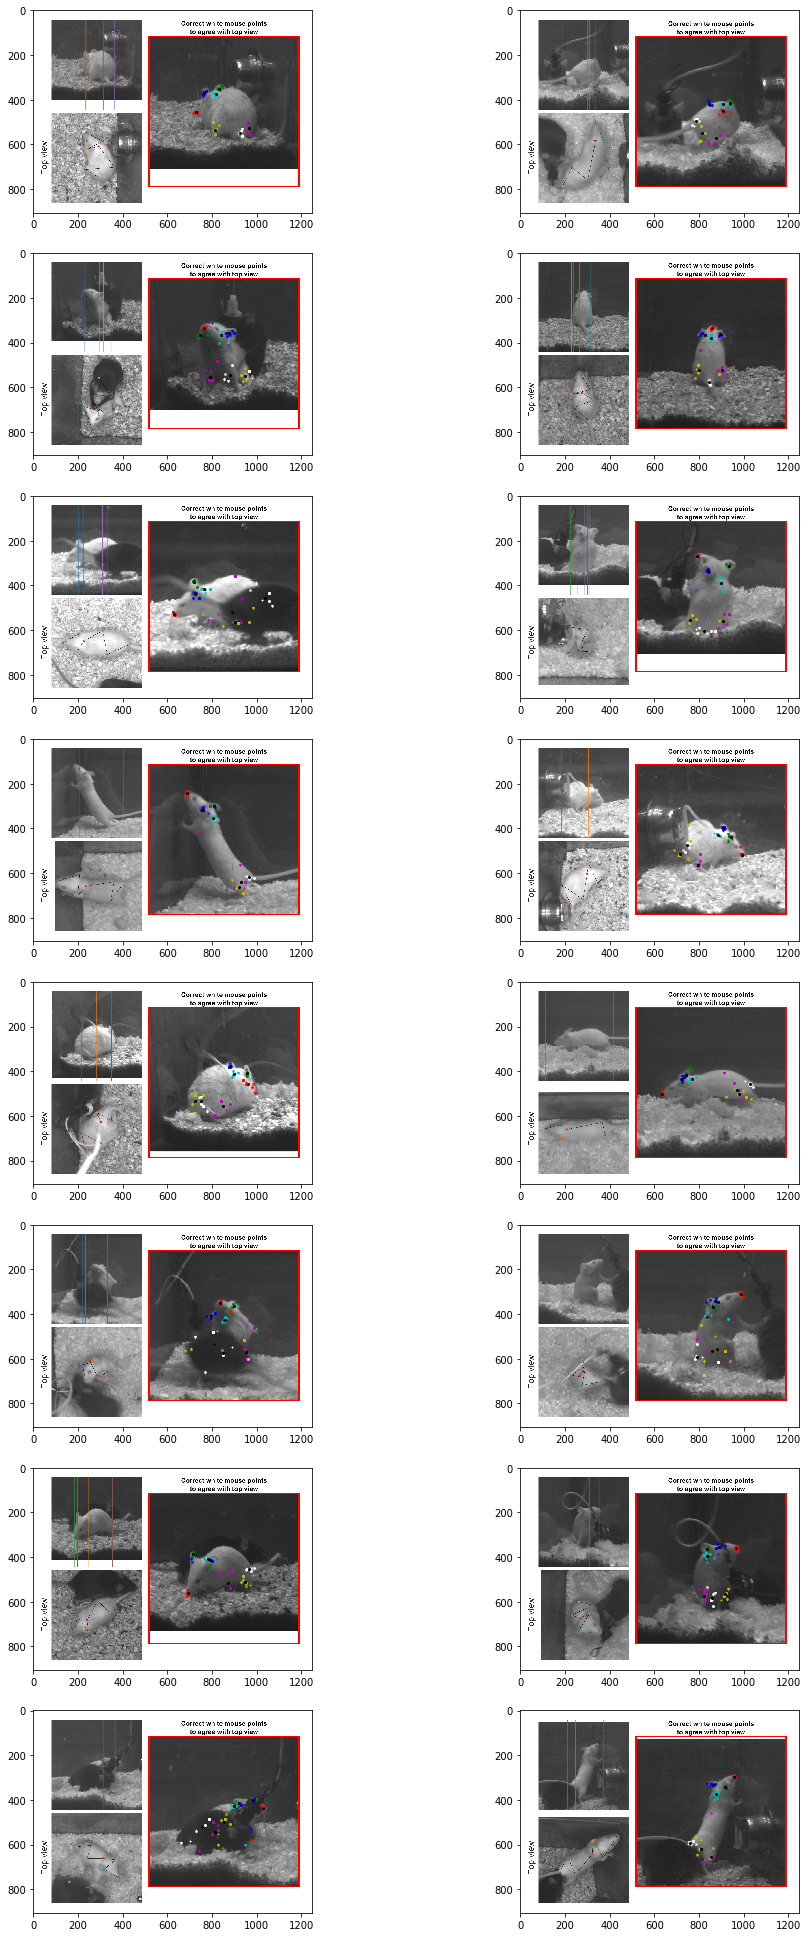

In [18]:
# let's look at a couple example images to see how our annotators did:
colors='rgbcmyw'
markers = 'v+xosd'
    
fig,ax = plt.subplots(8,2,figsize=(16, 35))
for fr in range(0,16):
    im = mpimg.imread(images[fr])
    ax[int(fr/2),(fr+1)%2].imshow(im);
    
    # plot the labels from each individual worker:
    for p,pt in enumerate(np.squeeze(allPts[fr,...])):
        for w in range(6):
            ax[int(fr/2),(fr+1)%2].plot(pt[0,w], pt[1,w],colors[p] + markers[w], markersize=2)
    
    # plot the "ground truth" labels:
    ax[int(fr/2),(fr+1)%2].plot(gtPts[fr,:,0], gtPts[fr,:,1],'k.', markersize=4)
        
fig.savefig(os.path.join('sample_data','generated_figures','white-mouse-test-100.pdf'), bbox_inches='tight')

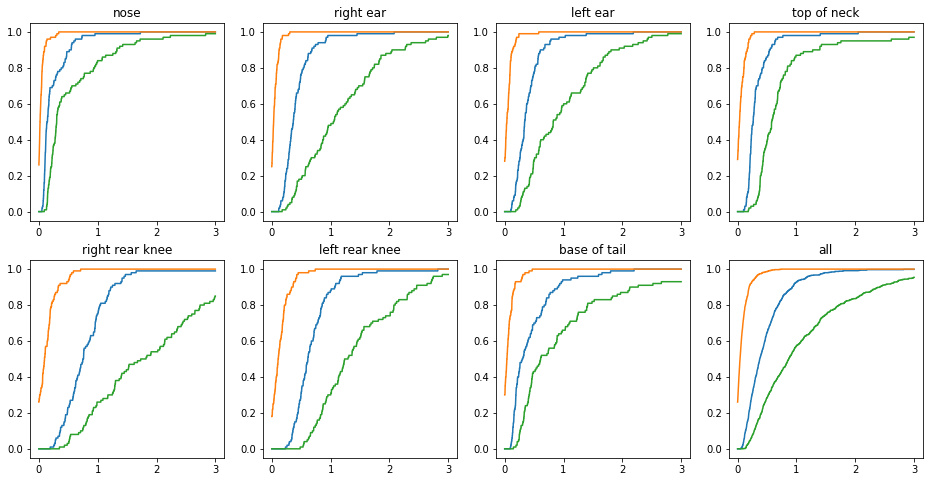

In [29]:
# now we'd like to quantify annotator variability. For some reason, this seems to be a good predictor
# of how well our pose estimator is going to do once trained.

pixels_per_cm = 54.378 # this is a little higher than the raw behvaior videos, because we zoomed in on the mouse to be labeled

dMean = np.zeros((nKpts,nSamp)) # average worker-gt distance
dMin  = np.zeros((nKpts,nSamp)) # performance of best worker on a given frame
dMax  = np.zeros((nKpts,nSamp)) # performance of worst worker on a given frame

for fr,(gt,est) in enumerate(zip(gtPts,allPts)):
    for pt,(gtPt,estPts) in enumerate(zip(gt,est)):
        D = cdist(estPts.T, [gtPt]) / pixels_per_cm
        dMean[pt,fr] = np.mean(D)
        dMin[pt,fr]  = min(D)
        dMax[pt,fr]  = max(D)
        
fig,ax = plt.subplots(2,4,figsize=(16, 8))

binSize = 0.001
bins = np.arange(0,3,binSize)

for use in [dMean,dMin,dMax]:
    for p,pt in enumerate(use):
        counts,_ = np.histogram(pt,bins)
        ax[int(p/4),p%4].plot(bins[1:],counts.cumsum()/nSamp)
        ax[int(p/4),p%4].set_title(order[p])

    counts,_ = np.histogram(use.ravel(),bins)
    ax[1,3].plot(bins[1:],counts.cumsum()/nSamp/nKpts)
    ax[1,3].set_title('all');

fig.savefig(os.path.join('sample_data','generated_figures','white-mouse-test-100_error_radii.pdf'), bbox_inches='tight')

In [ ]:
# repeating the plots for the uncorrected data as a sanity check

pixels_per_cm = 54.378 # this is a little higher than the raw behvaior videos, because we zoomed in on the mouse to be labeled

dMean = np.zeros((nKpts,nSamp)) # average worker-gt distance
dMin  = np.zeros((nKpts,nSamp)) # performance of best worker on a given frame
dMax  = np.zeros((nKpts,nSamp)) # performance of worst worker on a given frame

for fr,(gt,est) in enumerate(zip(gtPtsRaw,rawPts)):
    for pt,(gtPt,estPts) in enumerate(zip(gt,est)):
        D = cdist(estPts.T, [gtPt]) / pixels_per_cm
        dMean[pt,fr] = np.mean(D)
        dMin[pt,fr]  = min(D)
        dMax[pt,fr]  = max(D)
        
fig,ax = plt.subplots(2,4,figsize=(16, 8))

binSize = 0.001
bins = np.arange(0,2,binSize)

for use in [dMean,dMin,dMax]:
    for p,pt in enumerate(use):
        counts,_ = np.histogram(pt,bins)
        ax[int(p/4),p%4].plot(bins[1:],counts.cumsum()/nSamp)
        ax[int(p/4),p%4].set_title(order[p])

    counts,_ = np.histogram(use.ravel(),bins)
    ax[1,3].plot(bins[1:],counts.cumsum()/nSamp/nKpts)
    ax[1,3].set_title('all');